<a href="https://colab.research.google.com/github/fjadidi2001/DataScienceJourney/blob/master/insurance_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Load the dataset
from google.colab import drive
import pandas as pd
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

# Specify file path
file_path = '/content/drive/My Drive/telematics_syn.csv'

# Read the CSV file
data = pd.read_csv(file_path)

# Step 2: Explore the data
print("First few rows of the dataset:")
print(data.head())
print("\nDataset information:")
print(data.info())
print("\nChecking for missing values:")
print(data.isnull().sum())
print("\nBasic statistics:")
print(data.describe())

# Step 3: Create target variable ClaimYN
data['ClaimYN'] = ((data['NB_Claim'] >= 1) & (data['AMT_Claim'] >= 1000)).astype(int)

# Display distribution of ClaimYN
print("\nDistribution of ClaimYN:")
print(data['ClaimYN'].value_counts(normalize=True) * 100)
print("\nAbsolute counts:")
print(data['ClaimYN'].value_counts())

Mounted at /content/drive
First few rows of the dataset:
   Duration  Insured.age Insured.sex  Car.age  Marital  Car.use  Credit.score  \
0       366           45        Male       -1  Married  Commute         609.0   
1       182           44      Female        3  Married  Commute         575.0   
2       184           48      Female        6  Married  Commute         847.0   
3       183           71        Male        6  Married  Private         842.0   
4       183           84        Male       10  Married  Private         856.0   

  Region  Annual.miles.drive  Years.noclaims  ...  Left.turn.intensity10  \
0  Urban             6213.71              25  ...                    1.0   
1  Urban            12427.42              20  ...                   58.0   
2  Urban            12427.42              14  ...                    0.0   
3  Urban             6213.71              43  ...                    0.0   
4  Urban             6213.71              65  ...                    2.0   


In [ ]:
# Import required libraries
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd
import numpy as np

# Print initial column count
print("Initial number of columns:", len(data.columns))

# Separate features and target
# Exclude NB_Claim and AMT_Claim as they were used to create the target
features = data.drop(['ClaimYN', 'NB_Claim', 'AMT_Claim'], axis=1)
print("\nNumber of columns after dropping target and claim columns:", len(features.columns))

# Print categorical columns unique values
print("\nUnique values in categorical columns:")
categorical_columns = ['Insured.sex', 'Marital', 'Car.use', 'Region']
for col in categorical_columns:
    print(f"{col}: {features[col].unique()}")

# Convert categorical variables to numeric using one-hot encoding
features = pd.get_dummies(features, columns=categorical_columns)
print("\nColumns after one-hot encoding:")
print(features.columns.tolist())
print("\nTotal number of columns after encoding:", len(features.columns))

X = features
y = data['ClaimYN']

# Proceed with train-test split and SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Print final shapes
print("\nFinal dataset shapes:")
print(f"Original features: {X.shape}")
print(f"X_train_balanced: {X_train_balanced.shape}")
print(f"X_test: {X_test.shape}")

Initial number of columns: 53

Number of columns after dropping target and claim columns: 50

Unique values in categorical columns:
Insured.sex: ['Male' 'Female']
Marital: ['Married' 'Single']
Car.use: ['Commute' 'Private' 'Commercial' 'Farmer']
Region: ['Urban' 'Rural']

Columns after one-hot encoding:
['Duration', 'Insured.age', 'Car.age', 'Credit.score', 'Annual.miles.drive', 'Years.noclaims', 'Territory', 'Annual.pct.driven', 'Total.miles.driven', 'Pct.drive.mon', 'Pct.drive.tue', 'Pct.drive.wed', 'Pct.drive.thr', 'Pct.drive.fri', 'Pct.drive.sat', 'Pct.drive.sun', 'Pct.drive.2hrs', 'Pct.drive.3hrs', 'Pct.drive.4hrs', 'Pct.drive.wkday', 'Pct.drive.wkend', 'Pct.drive.rush am', 'Pct.drive.rush pm', 'Avgdays.week', 'Accel.06miles', 'Accel.08miles', 'Accel.09miles', 'Accel.11miles', 'Accel.12miles', 'Accel.14miles', 'Brake.06miles', 'Brake.08miles', 'Brake.09miles', 'Brake.11miles', 'Brake.12miles', 'Brake.14miles', 'Left.turn.intensity08', 'Left.turn.intensity09', 'Left.turn.intensity1

In [ ]:
# Import required libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np

# Feature Engineering
def create_aggregated_features(df):
    """Create aggregated features from existing ones"""

    # Aggregate acceleration features
    df['Agg_Accel'] = df[[
        'Accel.06miles', 'Accel.08miles', 'Accel.09miles',
        'Accel.11miles', 'Accel.12miles', 'Accel.14miles'
    ]].mean(axis=1)

    # Aggregate braking features
    df['Agg_Brake'] = df[[
        'Brake.06miles', 'Brake.08miles', 'Brake.09miles',
        'Brake.11miles', 'Brake.12miles', 'Brake.14miles'
    ]].mean(axis=1)

    # Aggregate left turn features
    df['Agg_Left_Turn'] = df[[
        'Left.turn.intensity08', 'Left.turn.intensity09', 'Left.turn.intensity10',
        'Left.turn.intensity11', 'Left.turn.intensity12'
    ]].mean(axis=1)

    # Aggregate right turn features
    df['Agg_Right_Turn'] = df[[
        'Right.turn.intensity08', 'Right.turn.intensity09', 'Right.turn.intensity10',
        'Right.turn.intensity11', 'Right.turn.intensity12'
    ]].mean(axis=1)

    # Create overall harsh driving score
    df['Harsh_Driving_Score'] = (
        df['Agg_Accel'] + df['Agg_Brake'] +
        df['Agg_Left_Turn'] + df['Agg_Right_Turn']
    ) / 4

    # Create rush hour driving ratio
    df['Rush_Hour_Ratio'] = (
        df['Pct.drive.rush am'] + df['Pct.drive.rush pm']
    ) / df['Total.miles.driven']

    return df

# Standardization function
def standardize_features(X_train, X_test):
    """Standardize numerical features"""
    scaler = StandardScaler()

    # Get numerical columns (exclude dummy variables)
    numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

    # Fit and transform training data
    X_train_scaled = X_train.copy()
    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])

    # Transform test data
    X_test_scaled = X_test.copy()
    X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

    return X_train_scaled, X_test_scaled, scaler

# Apply preprocessing pipeline
def preprocess_data(X_train, X_test):
    """Complete preprocessing pipeline"""

    # 1. Feature Engineering
    print("Applying feature engineering...")
    X_train = create_aggregated_features(X_train)
    X_test = create_aggregated_features(X_test)

    # 2. Standardization
    print("Standardizing features...")
    X_train_scaled, X_test_scaled, scaler = standardize_features(X_train, X_test)

    # Print feature names and their shapes
    print("\nFinal feature set:")
    print(f"Training set shape: {X_train_scaled.shape}")
    print(f"Test set shape: {X_test_scaled.shape}")
    print("\nFeatures included:")
    print(X_train_scaled.columns.tolist())

    return X_train_scaled, X_test_scaled, scaler

# Apply preprocessing to our balanced dataset
X_train_processed, X_test_processed, scaler = preprocess_data(X_train_balanced, X_test)

# Print sample statistics to verify preprocessing
print("\nSample statistics after preprocessing:")
print(X_train_processed.describe().round(2))

Applying feature engineering...
Standardizing features...

Final feature set:
Training set shape: (155684, 62)
Test set shape: (20000, 62)

Features included:
['Duration', 'Insured.age', 'Car.age', 'Credit.score', 'Annual.miles.drive', 'Years.noclaims', 'Territory', 'Annual.pct.driven', 'Total.miles.driven', 'Pct.drive.mon', 'Pct.drive.tue', 'Pct.drive.wed', 'Pct.drive.thr', 'Pct.drive.fri', 'Pct.drive.sat', 'Pct.drive.sun', 'Pct.drive.2hrs', 'Pct.drive.3hrs', 'Pct.drive.4hrs', 'Pct.drive.wkday', 'Pct.drive.wkend', 'Pct.drive.rush am', 'Pct.drive.rush pm', 'Avgdays.week', 'Accel.06miles', 'Accel.08miles', 'Accel.09miles', 'Accel.11miles', 'Accel.12miles', 'Accel.14miles', 'Brake.06miles', 'Brake.08miles', 'Brake.09miles', 'Brake.11miles', 'Brake.12miles', 'Brake.14miles', 'Left.turn.intensity08', 'Left.turn.intensity09', 'Left.turn.intensity10', 'Left.turn.intensity11', 'Left.turn.intensity12', 'Right.turn.intensity08', 'Right.turn.intensity09', 'Right.turn.intensity10', 'Right.turn.in

In [ ]:
!pip install pytorch_tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, roc_curve

# Deep Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# XGBoost
import xgboost as xgb

# TabNet
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

# Assuming X and y are your features and target variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Deep Neural Network
def create_dnn_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

dnn_model = create_dnn_model(X_train.shape[1])
dnn_history = dnn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# 2. XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# 3. TabNet
tabnet_model = TabNetClassifier(
    n_d=16, n_a=16, n_steps=5,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax'
)

X_train_tab = X_train.astype(np.float32)
y_train_tab = y_train.astype(np.int64)
X_test_tab = X_test.astype(np.float32)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, roc_curve

# Ensure TabNet is properly fitted
# Convert X_train_tab, X_test_tab to NumPy arrays before fitting
tabnet_model.fit(
    X_train_tab.values, y_train_tab,  # Use .values to get the NumPy array
    eval_set=[(X_test_tab.values, y_test.astype(np.int64))],  # Use .values here as well
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 0.14825 | val_0_auc: 0.54718 |  0:00:08s
epoch 1  | loss: 0.1147  | val_0_auc: 0.75003 |  0:00:13s
epoch 2  | loss: 0.11168 | val_0_auc: 0.79227 |  0:00:19s
epoch 3  | loss: 0.10895 | val_0_auc: 0.79463 |  0:00:25s
epoch 4  | loss: 0.10858 | val_0_auc: 0.80322 |  0:00:30s
epoch 5  | loss: 0.108   | val_0_auc: 0.80129 |  0:00:37s
epoch 6  | loss: 0.10857 | val_0_auc: 0.80574 |  0:00:42s
epoch 7  | loss: 0.10631 | val_0_auc: 0.80857 |  0:00:48s
epoch 8  | loss: 0.106   | val_0_auc: 0.80653 |  0:00:55s
epoch 9  | loss: 0.10564 | val_0_auc: 0.80469 |  0:01:00s
epoch 10 | loss: 0.10528 | val_0_auc: 0.81359 |  0:01:06s
epoch 11 | loss: 0.10495 | val_0_auc: 0.80905 |  0:01:12s
epoch 12 | loss: 0.10565 | val_0_auc: 0.80377 |  0:01:18s
epoch 13 | loss: 0.1055  | val_0_auc: 0.80445 |  0:01:23s
epoch 14 | loss: 0.10512 | val_0_auc: 0.81124 |  0:01:29s
epoch 15 | loss: 0.10532 | val_0_auc: 0.81088 |  0:01:35s
epoch 16 | loss: 0.10438 | val_0_auc: 0.80543 |  0:01:40s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [13]:
# Make predictions
y_pred_dnn = dnn_model.predict(X_test_scaled).ravel()
y_pred_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Convert X_test_tab columns to strings
# This ensures TabNet does not misinterpret column names as indices
X_test_tab.columns = X_test_tab.columns.astype(str)

# Now predict using TabNet
y_pred_tabnet = tabnet_model.predict_proba(X_test_tab.values)[:, 1]

# Ensemble predictions (simple average)
y_pred_ensemble = (y_pred_dnn + y_pred_xgb + y_pred_tabnet) / 3

# Calculate metrics for ensemble
y_pred_ensemble_class = (y_pred_ensemble > 0.5).astype(int)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step



Ensemble Model Performance Metrics:
accuracy: 0.9737
precision: 0.9524
recall: 0.0367
f1: 0.0707
auc: 0.8671
matthews_corr: 0.1842


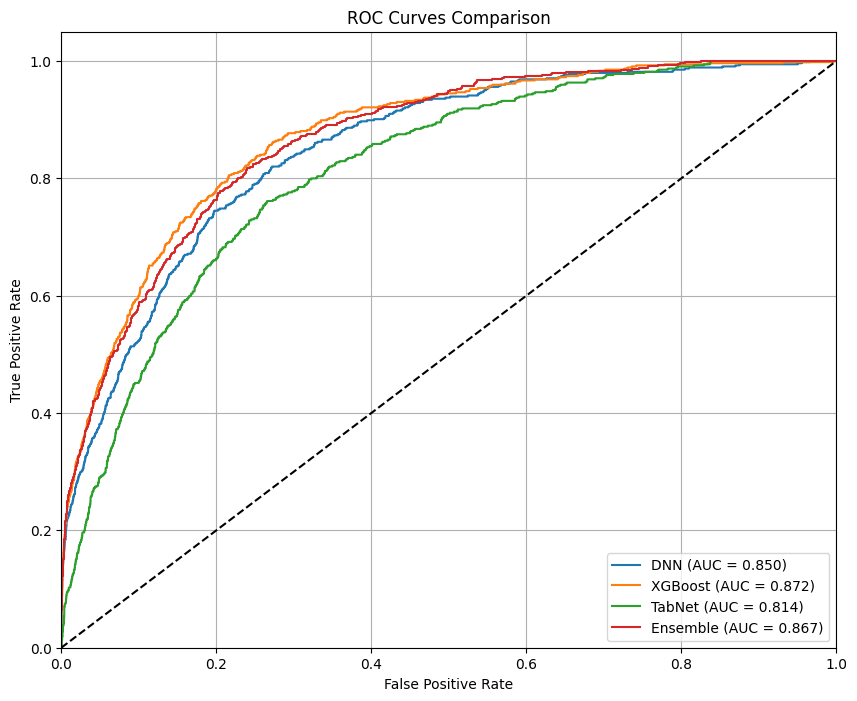

In [14]:

metrics_ensemble = {
    'accuracy': accuracy_score(y_test, y_pred_ensemble_class),
    'precision': precision_score(y_test, y_pred_ensemble_class),
    'recall': recall_score(y_test, y_pred_ensemble_class),
    'f1': f1_score(y_test, y_pred_ensemble_class),
    'auc': roc_auc_score(y_test, y_pred_ensemble),
    'matthews_corr': matthews_corrcoef(y_test, y_pred_ensemble_class)
}

# Print ensemble metrics
print("\nEnsemble Model Performance Metrics:")
for metric, value in metrics_ensemble.items():
    print(f"{metric}: {value:.4f}")

# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, y_pred in [('DNN', y_pred_dnn), ('XGBoost', y_pred_xgb), ('TabNet', y_pred_tabnet), ('Ensemble', y_pred_ensemble)]:
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [18]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.model_selection import StratifiedKFold

# Define a smaller parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'auc': make_scorer(roc_auc_score),
    'matthews_corr': make_scorer(matthews_corrcoef)
}


In [24]:
# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Set up RandomizedSearchCV with StratifiedKFold
n_iter_search = 2  # Number of parameter settings that are sampled
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=n_iter_search,
    scoring=scoring,
    refit='matthews_corr',  # Optimize for Matthews Correlation Coefficient
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the random search
print("Starting RandomizedSearchCV...")
random_search.fit(X_train, y_train)
print("RandomizedSearchCV completed.")



Starting RandomizedSearchCV...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
RandomizedSearchCV completed.


In [25]:
# Get the best model
best_rf = random_search.best_estimator_

# Make predictions with the best model
y_pred_rf = best_rf.predict(X_test)
y_pred_rf_proba = best_rf.predict_proba(X_test)[:, 1]

# Calculate metrics
metrics_rf = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf),
    'recall': recall_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf),
    'auc': roc_auc_score(y_test, y_pred_rf_proba),
    'matthews_corr': matthews_corrcoef(y_test, y_pred_rf)
}

# Print Random Forest metrics
print("\nOptimized Random Forest Model Performance Metrics:")
for metric, value in metrics_rf.items():
    print(f"{metric}: {value:.4f}")

# Print best parameters
print("\nBest Parameters:")
print(random_search.best_params_)

# Create new ensemble including Random Forest
y_pred_new_ensemble = (y_pred_dnn + y_pred_xgb + y_pred_tabnet + y_pred_rf_proba) / 4
y_pred_new_ensemble_class = (y_pred_new_ensemble > 0.5).astype(int)




Optimized Random Forest Model Performance Metrics:
accuracy: 0.9787
precision: 0.9338
recall: 0.2330
f1: 0.3730
auc: 0.9158
matthews_corr: 0.4607

Best Parameters:
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced'}



New Ensemble Model (including RF) Performance Metrics:
accuracy: 0.9745
precision: 0.9722
recall: 0.0642
f1: 0.1205
auc: 0.9163
matthews_corr: 0.2465


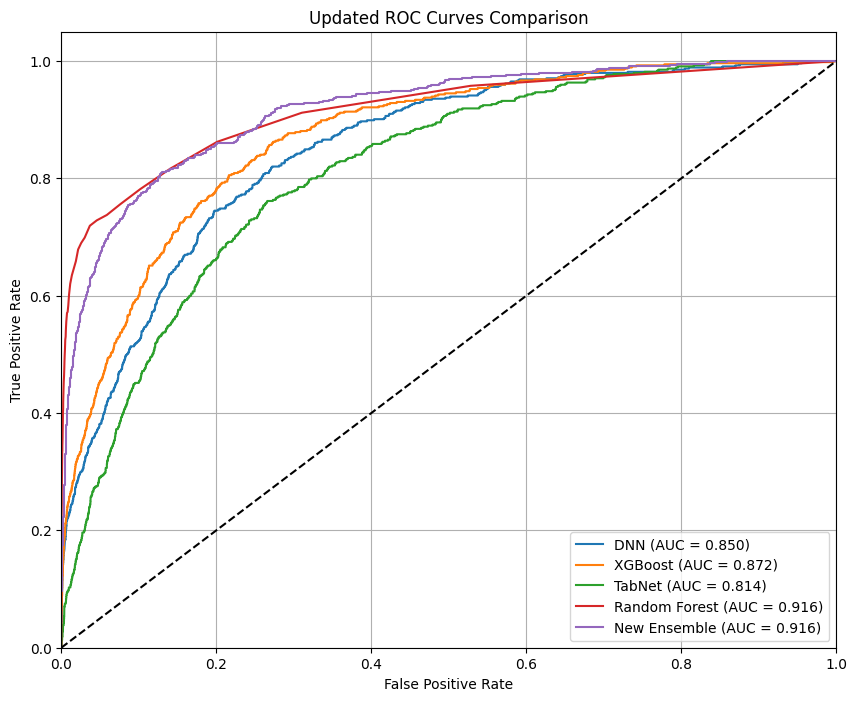

In [26]:
# Calculate metrics for new ensemble
metrics_new_ensemble = {
    'accuracy': accuracy_score(y_test, y_pred_new_ensemble_class),
    'precision': precision_score(y_test, y_pred_new_ensemble_class),
    'recall': recall_score(y_test, y_pred_new_ensemble_class),
    'f1': f1_score(y_test, y_pred_new_ensemble_class),
    'auc': roc_auc_score(y_test, y_pred_new_ensemble),
    'matthews_corr': matthews_corrcoef(y_test, y_pred_new_ensemble_class)
}

# Print new ensemble metrics
print("\nNew Ensemble Model (including RF) Performance Metrics:")
for metric, value in metrics_new_ensemble.items():
    print(f"{metric}: {value:.4f}")

# Plot updated ROC curves
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 8))
for name, y_pred in [('DNN', y_pred_dnn), ('XGBoost', y_pred_xgb),
                     ('TabNet', y_pred_tabnet), ('Random Forest', y_pred_rf_proba),
                     ('New Ensemble', y_pred_new_ensemble)]:
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Updated ROC Curves Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Generating out-of-fold predictions...
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Training base models...
Making predictions...

Stacking Ensemble Model Performance Metrics:
accuracy: 0.9747
precision: 0.5841
recall: 0.2422
f1: 0.3424
auc: 0.8564
matthews_corr: 0.3656


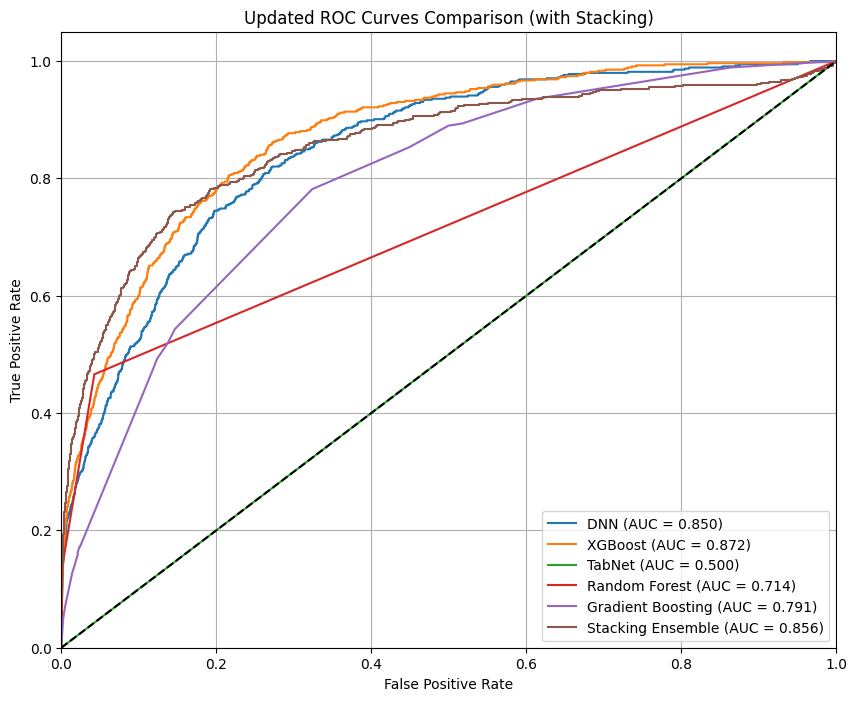

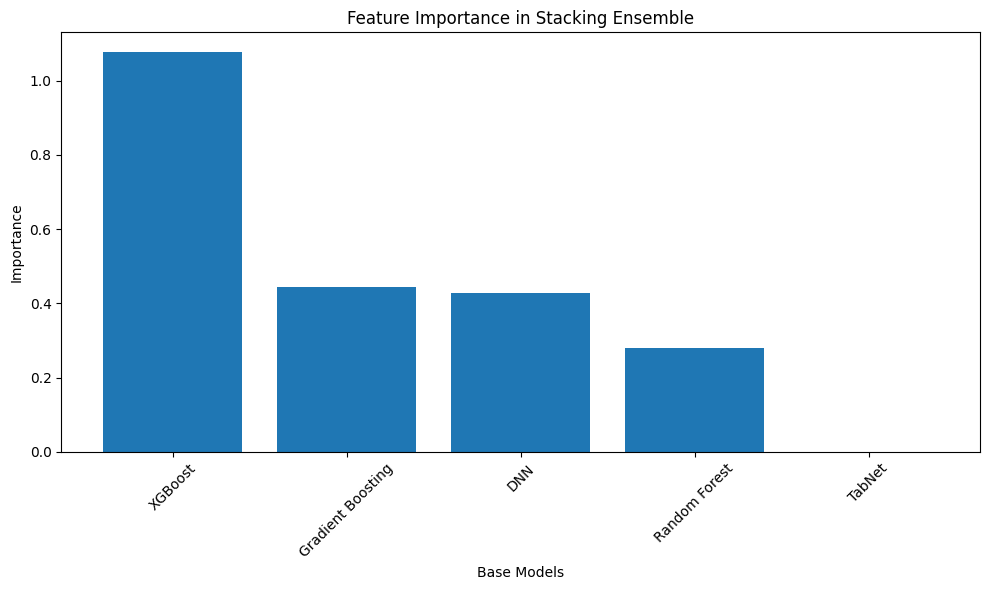

In [37]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.preprocessing import StandardScaler

# Function to get out-of-fold predictions
def get_oof_predictions(clf, X, y, cv=5):
    predictions = cross_val_predict(clf, X, y, cv=cv, method='predict_proba')
    return predictions[:, 1]

# Create base models
rf = RandomForestClassifier(n_estimators=2, random_state=42)
gb = GradientBoostingClassifier(n_estimators=2, random_state=42)

# Get out-of-fold predictions for each base model
print("Generating out-of-fold predictions...")
oof_rf = get_oof_predictions(rf, X_train, y_train)
oof_gb = get_oof_predictions(gb, X_train, y_train)

# For DNN and XGBoost, we need to generate predictions for the training set
# Assuming these models are already trained
oof_dnn = dnn_model.predict(X_train_scaled).ravel()
oof_xgb = xgb_model.predict_proba(X_train)[:, 1]

# For TabNet, we'll use a separate approach
try:
    oof_tabnet = tabnet_model.predict_proba(X_train_tab)[:, 1]
except KeyError:
    print("Warning: TabNet prediction failed. Using zeros as placeholder.")
    oof_tabnet = np.zeros(len(X_train))

# Create a new feature matrix using out-of-fold predictions
X_train_meta = np.column_stack((oof_rf, oof_gb, oof_dnn, oof_xgb, oof_tabnet))

# Scale the meta-features
scaler = StandardScaler()
X_train_meta_scaled = scaler.fit_transform(X_train_meta)

# Train a meta-model
meta_model = LogisticRegression(random_state=42)
meta_model.fit(X_train_meta_scaled, y_train)

# Train base models on the full training data
print("Training base models...")
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

# Make predictions on the test set
print("Making predictions...")
test_rf = rf.predict_proba(X_test)[:, 1]
test_gb = gb.predict_proba(X_test)[:, 1]
test_dnn = y_pred_dnn  # Assuming this is already computed for the test set
test_xgb = y_pred_xgb  # Assuming this is already computed for the test set

# For TabNet, use the same approach as for training
try:
    test_tabnet = tabnet_model.predict_proba(X_test_tab)[:, 1]
except KeyError:
    print("Warning: TabNet prediction failed for test set. Using zeros as placeholder.")
    test_tabnet = np.zeros(len(X_test))

# Create test meta-features
X_test_meta = np.column_stack((test_rf, test_gb, test_dnn, test_xgb, test_tabnet))
X_test_meta_scaled = scaler.transform(X_test_meta)

# Make final predictions
y_pred_stacking = meta_model.predict(X_test_meta_scaled)
y_pred_stacking_proba = meta_model.predict_proba(X_test_meta_scaled)[:, 1]

# Calculate metrics for stacking ensemble
metrics_stacking = {
    'accuracy': accuracy_score(y_test, y_pred_stacking),
    'precision': precision_score(y_test, y_pred_stacking),
    'recall': recall_score(y_test, y_pred_stacking),
    'f1': f1_score(y_test, y_pred_stacking),
    'auc': roc_auc_score(y_test, y_pred_stacking_proba),
    'matthews_corr': matthews_corrcoef(y_test, y_pred_stacking)
}

# Print stacking ensemble metrics
print("\nStacking Ensemble Model Performance Metrics:")
for metric, value in metrics_stacking.items():
    print(f"{metric}: {value:.4f}")

# Plot updated ROC curves
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 8))
for name, y_pred in [('DNN', y_pred_dnn), ('XGBoost', y_pred_xgb),
                     ('TabNet', test_tabnet), ('Random Forest', test_rf),
                     ('Gradient Boosting', test_gb),
                     ('Stacking Ensemble', y_pred_stacking_proba)]:
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Updated ROC Curves Comparison (with Stacking)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Feature importance of the meta-model
feature_importance = pd.DataFrame({
    'feature': ['Random Forest', 'Gradient Boosting', 'DNN', 'XGBoost', 'TabNet'],
    'importance': np.abs(meta_model.coef_[0])  # Use absolute values for importance
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance in Stacking Ensemble')
plt.xlabel('Base Models')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()